# Assignment 8 submission: Autoencoders

## Group members: Divya Sasidharan, Poornima Venkatesha, Sinchana Eshwarappa Prameela

## Autoencoders in Tensorflow

Source: [Building Autoencoders in keras](https://blog.keras.io/building-autoencoders-in-keras.html)

In [0]:
%tensorflow_version 2.x 

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense
from keras.models import Model

Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step
(60000, 784)
(10000, 784)


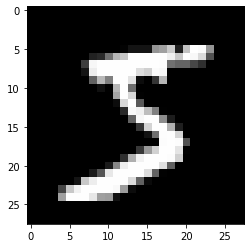

In [0]:
from keras.datasets import mnist
(x_train, _), (x_test, _) = mnist.load_data() # discarding the labels (since we're only interested in encoding/decoding the input images)

plt.imshow(x_train[0], cmap="Greys_r")

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

In [0]:
# this is the size of our encoded representations
encoding_dim = 128  

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
encoded = Dense(int(encoding_dim/2), activation='relu')(encoded)
encoded = Dense(int(encoding_dim/2), activation='relu')(encoded)
encoded = Dense(int(encoding_dim/2), activation='relu')(encoded)
encoded = Dense(int(encoding_dim/2), activation='relu')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded) #loss 0.1099
#decoded = Dense(784, activation='relu')(encoded) #0.0267
#decoded = Dense(784, activation='linear')(encoded) #0.0248 #reconstructed images not clear at all
# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [0]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [0]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(int(encoding_dim/2),))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [0]:
#use a per-pixel binary crossentropy loss, and the Adadelta optimizer
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy') #loss 0.1099
#autoencoder.compile(optimizer='adadelta', loss='MSE') #0.0267 -- reconstruction not perfect. distorted. few pixels missing

In [0]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.3432 - val_loss: 0.2617
Epoch 2/50
60000/60000 [==============================] - 1s 18us/step - loss: 0.2526 - val_loss: 0.2441
Epoch 3/50
60000/60000 [==============================] - 1s 19us/step - loss: 0.2393 - val_loss: 0.2318
Epoch 4/50
60000/60000 [==============================] - 1s 18us/step - loss: 0.2203 - val_loss: 0.2083
Epoch 5/50
60000/60000 [==============================] - 1s 18us/step - loss: 0.2008 - val_loss: 0.1924
Epoch 6/50
60000/60000 [==============================] - 1s 19us/step - loss: 0.1890 - val_loss: 0.1830
Epoch 7/50
60000/60000 [==============================] - 1s 18us/step - loss: 0.1810 - val_loss: 0.1775
Epoch 8/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.1772 - val_loss: 0.1732
Epoch 9/50
60000/60000 [==============================] - 1s 18us/step - loss: 0.1728 - val_loss: 0.1693
Epoch

In [0]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

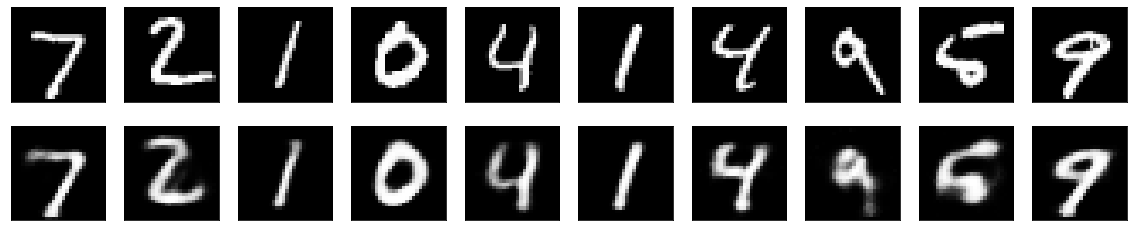

In [0]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Experiments:

1) Using sigmoid activation function in the last decoder layer and binary cross entropy loss funtion: Loss 0.1109

2) With relu and MSE: Loss 0.0267. Reconstruction is not good. 

3) With Linear activation and MSE: Loss 0.0248. Reconstruction is not perfect and are slightly distorted. Few pixels are missing.

## Convolutional Autoencoders

Source: [Building Autoencoders in keras](https://blog.keras.io/building-autoencoders-in-keras.html)

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [0]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  

Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step


In [0]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Reshape
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)


x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

"""
x = Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same', activation='relu')(encoded)
x = Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = Conv2DTranspose(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
x = Conv2DTranspose(filters=1, kernel_size=3, strides=2, padding='same', activation='relu')(x)
decoded = Conv2DTranspose(1, (3, 3), strides=1, activation='sigmoid', padding='same')(x)
"""

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [0]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 13s 215us/step - loss: 0.2088 - val_loss: 0.1640
Epoch 2/50
60000/60000 [==============================] - 6s 102us/step - loss: 0.1545 - val_loss: 0.1458
Epoch 3/50
60000/60000 [==============================] - 7s 109us/step - loss: 0.1410 - val_loss: 0.1369
Epoch 4/50
60000/60000 [==============================] - 7s 115us/step - loss: 0.1339 - val_loss: 0.1312
Epoch 5/50
60000/60000 [==============================] - 7s 116us/step - loss: 0.1294 - val_loss: 0.1251
Epoch 6/50
60000/60000 [==============================] - 7s 114us/step - loss: 0.1261 - val_loss: 0.1245
Epoch 7/50
60000/60000 [==============================] - 7s 115us/step - loss: 0.1237 - val_loss: 0.1184
Epoch 8/50
60000/60000 [==============================] - 7s 116us/step - loss: 0.1213 - val_loss: 0.1219
Epoch 9/50
60000/60000 [==============================] - 7s 116us/step - loss: 0.1196 - val_loss: 0.

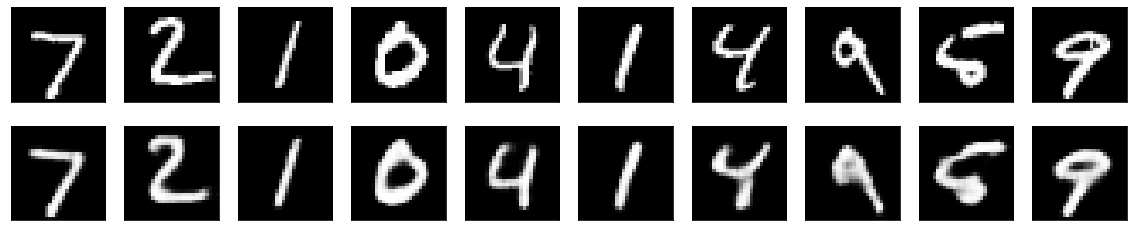

In [0]:
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## What do Autoencoders Learn?

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

Using TensorFlow backend.


In [0]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 5  

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [0]:
encoder = Model(input_img, encoded)
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [5]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 19us/step - loss: 0.4138 - val_loss: 0.2757
Epoch 2/50
60000/60000 [==============================] - 1s 15us/step - loss: 0.2730 - val_loss: 0.2698
Epoch 3/50
60000/60000 [==============================] - 1s 14us/step - loss: 0.2676 - val_loss: 0.2638
Epoch 4/50
60000/60000 [==============================] - 1s 14us/step - loss: 0.2594 - val_loss: 0.2526
Epoch 5/50
60000/60000 [==============================] - 1s 14us/step - loss: 0.2466 - val_loss: 0.2397
Epoch 6/50
60000/60000 [==============================] - 1s 14us/step - loss: 0.2361 - val_loss: 0.2319
Epoch 7/50
60000/60000 [==============================] - 1s 13us/step - loss: 0.2302 - val_loss: 0.2273
Epoch 8/50
60000/60000 [==============================] - 1s 13us/step - loss: 0.2264 - val_loss: 0.2235
Epoch 9/50
60000/60000 [==============================] - 1s 13us/step - loss: 0.2219 - val_loss: 0.2180
Epoch

In [0]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

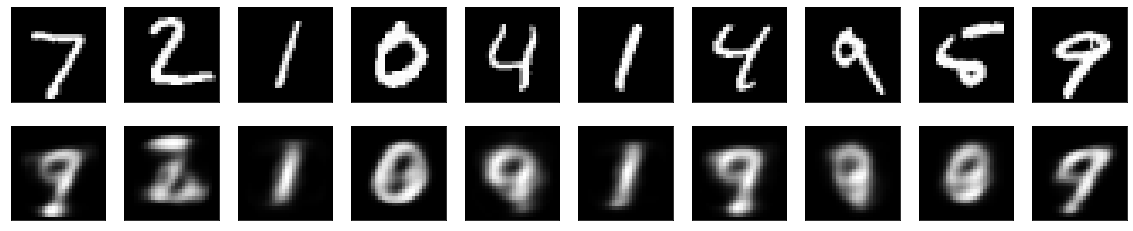

In [7]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Experiments

1) Gradually incresing the number of encoding dimensions improves the decoded images. In each step, we can see the strokes of MNIST digits becoming more meaningful. In the above example, we can see the strokes getting learnt as encoding_dim increases.

# Unsupervised pre-training

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [0]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [0]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# Train an autoencoder as before.

In [17]:
# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 14us/step - loss: 0.3585 - val_loss: 0.2710
Epoch 2/50
60000/60000 [==============================] - 1s 14us/step - loss: 0.2640 - val_loss: 0.2536
Epoch 3/50
60000/60000 [==============================] - 1s 14us/step - loss: 0.2426 - val_loss: 0.2292
Epoch 4/50
60000/60000 [==============================] - 1s 14us/step - loss: 0.2207 - val_loss: 0.2102
Epoch 5/50
60000/60000 [==============================] - 1s 14us/step - loss: 0.2048 - val_loss: 0.1969
Epoch 6/50
60000/60000 [==============================] - 1s 16us/step - loss: 0.1937 - val_loss: 0.1877
Epoch 7/50
60000/60000 [==============================] - 1s 14us/step - loss: 0.1854 - val_loss: 0.1804
Epoch 8/50
60000/60000 [==============================] - 1s 14us/step - loss: 0.1788 - val_loss: 0.1743
Epoch 9/50
60000/60000 [==============================] - 1s 13us/step - loss: 0.1733 - val_loss: 0.1694
Epoch

# Take a small random subset of the training data. Make sure it is actually random, i.e. all labels are represented. You could go very low, e.g. 100 elements or so.

In [18]:
from keras.datasets import mnist
from keras.utils import to_categorical
import matplotlib.pyplot as plt

(inputs_train, targets_train),(inputs_test, targets_test) = mnist.load_data()

inputs_train = inputs_train[:100].reshape(100, 784)
targets_train = to_categorical(targets_train[:100])

inputs_test = inputs_test.reshape(len(inputs_test),784)
targets_test = to_categorical(targets_test)
#print(targets_train)
print(inputs_train.shape)
print(targets_train.shape)

print(inputs_test.shape)
print(targets_test.shape)

(100, 784)
(100, 10)
(10000, 784)
(10000, 10)


# Take the encoder part of the autoencoder. Stick a classifier on top and train only this layer on the subset of data. Your model will now learn a classifier based on the fixed features that were learned by the autoencoder.

In [0]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD
from keras.regularizers import l2
encoding_dim = 10
num_classes = targets_train.shape[1]
inp = Input(shape=(784,))
encoded_1 = Dense(encoding_dim, activation='relu')(inp)
encoded_2=Dense(units=num_classes,activation='softmax',name='classify')(encoded_1)

decoded = Dense(784, activation='sigmoid')(encoded_1)

#autoencoder model
autoencoder = Model(inp, decoded)

#Separate decoder layer
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [0]:
learning_rate = 0.01
regularization = 1e-6

In [21]:
encoder_1 = Model(inp, encoded_2)
encoder_1.compile(optimizer=SGD(lr=learning_rate, momentum=0.9),
                  loss='binary_crossentropy')

h=encoder_1.fit(inputs_train,
        targets_train,
        batch_size=32,
        epochs=5,
        verbose=0)
h.history['loss']

[2.629176254272461,
 2.645204086303711,
 2.706720199584961,
 2.7374784088134767,
 2.737478485107422]